In [ ]:
!pip3 install split-folders
!pip3 install -U tensorflow-addons
import keras
%matplotlib inline 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
import splitfolders
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
SEED = 1234
img_size = 224

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
input_dir="/content/drive/MyDrive/Grapevine_Leaves_Image_Dataset" 

In [ ]:
adam=Adam(learning_rate=0.001)

In [ ]:
def get_label(Y):
  labels = []
  for y in Y:
    yy = np.array(y)
    i = np.argmax(yy)
    labels.append(i)

  return np.array(labels)

In [ ]:
def get_confusion_matrix(y_true, y_pred):
  y_pred_labels = get_label(y_pred)
  y_true_labels = get_label(y_test)
  print(tf.math.confusion_matrix(y_true_labels, y_pred_labels))

In [ ]:
image_size = (224,224)
batch_size = 32
all_ds = tf.keras.preprocessing.image_dataset_from_directory(
    input_dir,
    seed=SEED,
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
)

Found 500 files belonging to 5 classes.


In [ ]:
X_all = []
y_all = []

for x,y in all_ds.unbatch():
  X_all.append(x)
  y_all.append(y)

X_all = np.array(X_all)
y_all = np.array(y_all)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_all, y_all, test_size=0.2)
X_all = []
y_all = []

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
train_datagen = ImageDataGenerator(width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.2,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         vertical_flip = True,
                         rescale=1./255)
rescale_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
new_X_train = []
new_y_train = []

In [ ]:
for i in range(400):
  x = np.array(X_train[i])
  x = np.expand_dims(x, 0)
  imgenerator = train_datagen.flow(x, batch_size = 1)
  for j in range(10):
    batch = imgenerator.next()
    new_X_train.append(batch[0])
    new_y_train.append(y_train[i])

In [ ]:
new_X_train = np.array(new_X_train)
new_y_train = np.array(new_y_train)

In [ ]:
X_test = X_test/255

In [ ]:
X_train = X_train / 255

(224, 224, 3)


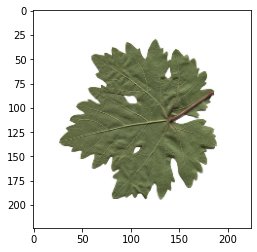

In [ ]:
print(X_train[1].shape)
plt.imshow(X_train[1])

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


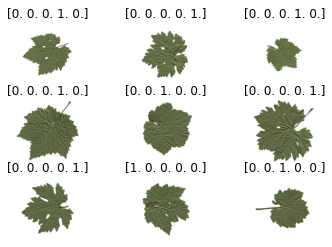

In [ ]:
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i])
  plt.title(y_train[i])
  plt.axis("off")

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(np.concatenate((X_train,new_X_train)), np.concatenate((y_train,new_y_train)), test_size=0.2)

In [ ]:
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
X_train = np.array(X_train)
y_train = np.array(y_train)
new_X_train = []
new_y_train = []

# **First CNN Model**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (img_size,img_size,3)) ,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu"), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000,activation="relu"),      
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(500,activation="relu"),   
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(400,activation ="relu"),
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.3,seed = SEED),
    tf.keras.layers.Dense(5,activation = "softmax")  
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 32)     128       
 hNormalization)                                                 
                                                        

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ['acc'])

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid,y_valid),
                    steps_per_epoch=len(X_train)//batch_size,
                    epochs=25,
                    validation_steps=len(X_valid)//batch_size,
                    verbose=1)

Epoch 1/25
110/110 [==============================] - 16s 56ms/step - loss: 2.6183 - acc: 0.2045 - val_loss: 1.6214 - val_acc: 0.1773
Epoch 2/25
110/110 [==============================] - 5s 46ms/step - loss: 1.8998 - acc: 0.2085 - val_loss: 1.6122 - val_acc: 0.2000
Epoch 3/25
110/110 [==============================] - 5s 46ms/step - loss: 1.7855 - acc: 0.1963 - val_loss: 1.6067 - val_acc: 0.2159
Epoch 4/25
110/110 [==============================] - 5s 46ms/step - loss: 1.7240 - acc: 0.2099 - val_loss: 1.6069 - val_acc: 0.2227
Epoch 5/25
110/110 [==============================] - 5s 46ms/step - loss: 1.6952 - acc: 0.2094 - val_loss: 1.6055 - val_acc: 0.2239
Epoch 6/25
110/110 [==============================] - 5s 46ms/step - loss: 1.6742 - acc: 0.2054 - val_loss: 1.6061 - val_acc: 0.2318
Epoch 7/25
110/110 [==============================] - 6s 54ms/step - loss: 1.6822 - acc: 0.1983 - val_loss: 1.6088 - val_acc: 0.2159
Epoch 8/25
110/110 [==============================] - 5s 46ms/step -

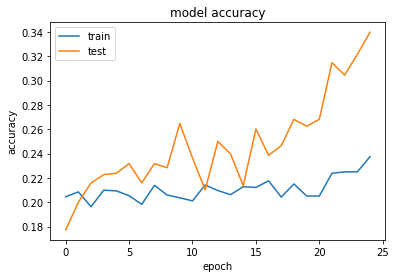

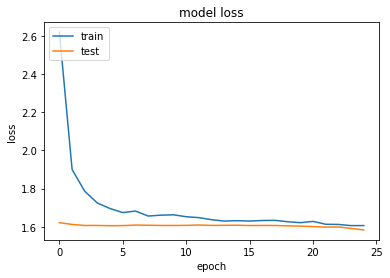

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
result = model.evaluate(X_test,y_test)
print(dict(zip(model.metrics_names, result)))
y_pred = model.predict(X_test)
get_confusion_matrix(y_test, y_pred)

4/4 [==============================] - 0s 41ms/step - loss: 1.5678 - acc: 0.3200
{'loss': 1.567786455154419, 'acc': 0.3199999928474426}
tf.Tensor(
[[ 7  3  0  1 11]
 [ 0  5  1  1 14]
 [ 1  0  0  0 21]
 [ 0  0  0  1 15]
 [ 0  0  0  0 19]], shape=(5, 5), dtype=int32)


In [ ]:
prediction = model.predict(X_test)

In [ ]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
 import sklearn
 from sklearn.metrics import classification_report

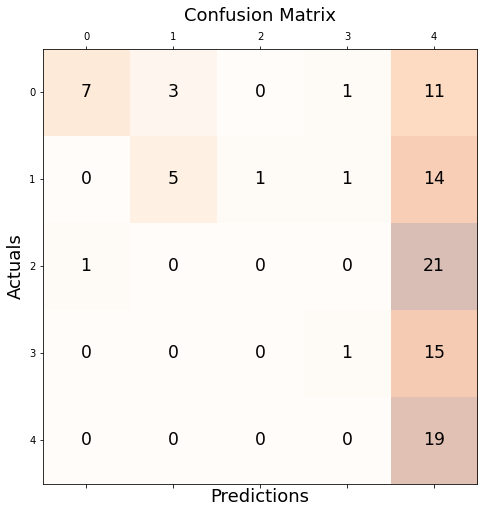

In [ ]:
y_pred_bool = np.argmax(prediction, axis=1)
y_test_bool = np.argmax(y_test, axis=1)
conf_matrix = sklearn.metrics.confusion_matrix(y_pred=y_pred_bool , y_true=y_test_bool)
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print(classification_report(y_test_bool, y_pred_bool))

              precision    recall  f1-score   support

           0       0.88      0.32      0.47        22
           1       0.62      0.24      0.34        21
           2       0.00      0.00      0.00        22
           3       0.33      0.06      0.11        16
           4       0.24      1.00      0.38        19

    accuracy                           0.32       100
   macro avg       0.41      0.32      0.26       100
weighted avg       0.42      0.32      0.26       100



Pre-Trained Models

In [ ]:
model1 = tf.keras.models.Sequential()
model2 = tf.keras.models.Sequential()
VGG = VGG16(input_shape = (224, 224, 3), 
                 pooling="avg",
                 include_top = False, 
                 weights = 'imagenet')
mobilenetv2 = tf.keras.applications.MobileNetV2(
    input_shape=(img_size,img_size,3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
)

# **VGG16**

In [ ]:
for layer in VGG.layers:
  layer.trainable = False

In [ ]:
model1.add(VGG)

In [ ]:
model1.add(tf.keras.layers.Dense(256,activation="relu"))
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(256,activation="relu"))
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(128,activation="relu"))
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(5,activation="softmax"))

In [ ]:
model1.compile(optimizer=Adam(learning_rate= 0.001), loss='categorical_crossentropy', metrics = ['acc'])

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)              

In [ ]:
history1 = model1.fit(X_train, y_train,
                    validation_data=(X_valid,y_valid),
                    steps_per_epoch=len(X_train)//batch_size,
                    epochs=50,
                    validation_steps=len(X_valid)//batch_size,
                    verbose=1)

Epoch 1/50
110/110 [==============================] - 34s 276ms/step - loss: 1.6301 - acc: 0.2324 - val_loss: 1.5433 - val_acc: 0.3159
Epoch 2/50
110/110 [==============================] - 22s 202ms/step - loss: 1.4633 - acc: 0.3494 - val_loss: 1.2498 - val_acc: 0.5023
Epoch 3/50
110/110 [==============================] - 27s 248ms/step - loss: 1.2204 - acc: 0.4787 - val_loss: 0.9982 - val_acc: 0.5977
Epoch 4/50
110/110 [==============================] - 22s 201ms/step - loss: 1.0794 - acc: 0.5409 - val_loss: 0.9059 - val_acc: 0.6443
Epoch 5/50
110/110 [==============================] - 22s 203ms/step - loss: 0.9534 - acc: 0.6006 - val_loss: 0.7859 - val_acc: 0.6807
Epoch 6/50
110/110 [==============================] - 22s 200ms/step - loss: 0.8812 - acc: 0.6372 - val_loss: 0.6711 - val_acc: 0.7511
Epoch 7/50
110/110 [==============================] - 22s 200ms/step - loss: 0.8243 - acc: 0.6773 - val_loss: 0.6629 - val_acc: 0.7284
Epoch 8/50
110/110 [==============================] - 2

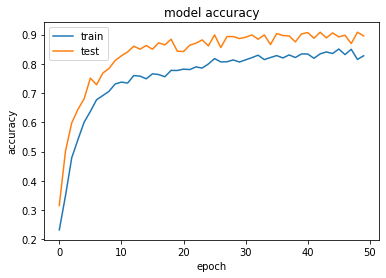

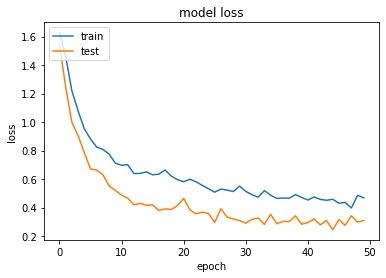

In [ ]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
result = model1.evaluate(X_test, y_test)
print(dict(zip(model1.metrics_names, result)))
y_pred = model1.predict(X_test)
get_confusion_matrix(y_test, y_pred)

4/4 [==============================] - 1s 397ms/step - loss: 0.3316 - acc: 0.8900
{'loss': 0.331604540348053, 'acc': 0.8899999856948853}
tf.Tensor(
[[21  0  0  1  0]
 [ 0 15  4  0  2]
 [ 0  2 20  0  0]
 [ 0  0  1 15  0]
 [ 0  0  1  0 18]], shape=(5, 5), dtype=int32)


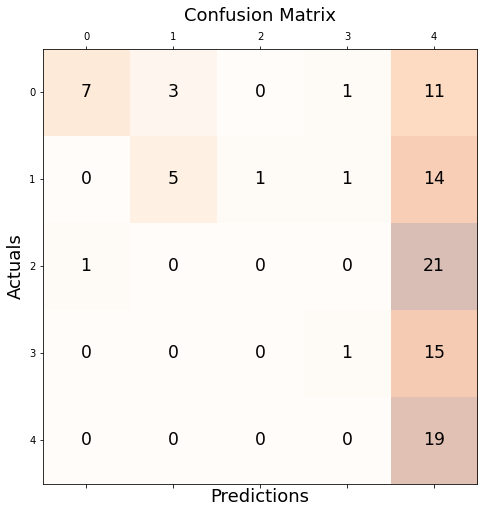

In [ ]:
y_pred_bool = np.argmax(prediction, axis=1)
y_test_bool = np.argmax(y_test, axis=1)
conf_matrix = sklearn.metrics.confusion_matrix(y_pred=y_pred_bool , y_true=y_test_bool)
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print(classification_report(y_test_bool, y_pred_bool))

              precision    recall  f1-score   support

           0       0.88      0.32      0.47        22
           1       0.62      0.24      0.34        21
           2       0.00      0.00      0.00        22
           3       0.33      0.06      0.11        16
           4       0.24      1.00      0.38        19

    accuracy                           0.32       100
   macro avg       0.41      0.32      0.26       100
weighted avg       0.42      0.32      0.26       100



## **Mobilenetv2**

In [ ]:
for layer in mobilenetv2.layers:
  layer.trainable = False

In [ ]:
model2.add(mobilenetv2)

In [ ]:
model2.add(tf.keras.layers.Dense(256,activation="relu"))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(256,activation="relu"))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(128,activation="relu"))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(5,activation="softmax"))

In [ ]:
model2.compile(optimizer=Adam(learning_rate= 0.001), loss='categorical_crossentropy', metrics = ['acc'])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                      

In [ ]:
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_valid,y_valid),
                    steps_per_epoch=len(X_train)//batch_size,
                    epochs=50,
                    validation_steps=len(X_valid)//batch_size,
                    verbose=1)

Epoch 1/50
110/110 [==============================] - 19s 72ms/step - loss: 1.4489 - acc: 0.3798 - val_loss: 0.9445 - val_acc: 0.6886
Epoch 2/50
110/110 [==============================] - 6s 54ms/step - loss: 0.9899 - acc: 0.5920 - val_loss: 0.7037 - val_acc: 0.7625
Epoch 3/50
110/110 [==============================] - 6s 54ms/step - loss: 0.8211 - acc: 0.6926 - val_loss: 0.5674 - val_acc: 0.8114
Epoch 4/50
110/110 [==============================] - 6s 54ms/step - loss: 0.7288 - acc: 0.7352 - val_loss: 0.5424 - val_acc: 0.8193
Epoch 5/50
110/110 [==============================] - 6s 56ms/step - loss: 0.6443 - acc: 0.7651 - val_loss: 0.4909 - val_acc: 0.8148
Epoch 6/50
110/110 [==============================] - 6s 54ms/step - loss: 0.6169 - acc: 0.7756 - val_loss: 0.4677 - val_acc: 0.8352
Epoch 7/50
110/110 [==============================] - 6s 54ms/step - loss: 0.5537 - acc: 0.8006 - val_loss: 0.3970 - val_acc: 0.8523
Epoch 8/50
110/110 [==============================] - 6s 54ms/step -

In [ ]:
result = model2.evaluate(X_test, y_test)
print(dict(zip(model2.metrics_names, result)))
y_pred = model2.predict(X_test)
get_confusion_matrix(y_test, y_pred)

4/4 [==============================] - 0s 111ms/step - loss: 0.3063 - acc: 0.8800
{'loss': 0.30625876784324646, 'acc': 0.8799999952316284}
tf.Tensor(
[[21  1  1  0  0]
 [ 1 19  5  0  0]
 [ 0  1 12  0  1]
 [ 0  0  0 19  1]
 [ 0  0  1  0 17]], shape=(5, 5), dtype=int32)


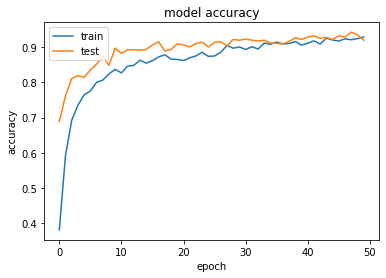

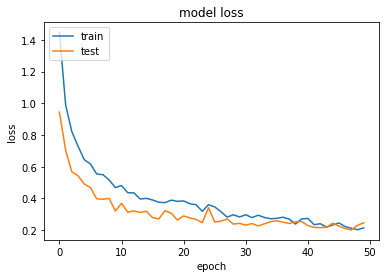

In [ ]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras import backend as K

## **AutoEncoder**

In [ ]:
inputShape = (img_size, img_size, 3)
chanDim = -1
inputs = tf.keras.layers.Input(shape=inputShape)
x = inputs

x = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization(axis=chanDim)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization(axis=chanDim)(x)
volumeSize = K.int_shape(x)
x = tf.keras.layers.Flatten()(x)
latent = tf.keras.layers.Dense(500)(x)

encoder = tf.keras.models.Model(inputs, latent, name="encoder")
latentInputs = tf.keras.layers.Input(shape=(500,))
x = tf.keras.layers.Dense(np.prod(volumeSize[1:]))(latentInputs)
x = tf.keras.layers.Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2,padding="same")(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization(axis=chanDim)(x)

x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2,padding="same")(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization(axis=chanDim)(x)

x = tf.keras.layers.Conv2DTranspose(3, (3, 3), padding="same")(x)
outputs = tf.keras.layers.Activation("sigmoid")(x)

decoder = tf.keras.models.Model(latentInputs, outputs, name="decoder")

autoencoder = tf.keras.models.Model(inputs, decoder(encoder(inputs)),name="autoencoder")


In [ ]:
noise_factor = 0.1
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
x_valid_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape) 

testx = x_train_noisy

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

In [ ]:
input_img = keras.Input(shape=(img_size, img_size, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
encodermain = tf.keras.models.Model(input_img, encoded, name="encoder")

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.compile(adam, loss="mse")

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=25,
                batch_size=10,
                shuffle=True,
                validation_data=(X_valid, X_valid))

Epoch 1/25
352/352 [==============================] - 25s 37ms/step - loss: 0.0095 - val_loss: 0.0013
Epoch 2/25
352/352 [==============================] - 12s 34ms/step - loss: 0.0011 - val_loss: 9.7155e-04
Epoch 3/25
352/352 [==============================] - 12s 34ms/step - loss: 8.8067e-04 - val_loss: 8.5946e-04
Epoch 4/25
352/352 [==============================] - 12s 34ms/step - loss: 7.4813e-04 - val_loss: 7.0118e-04
Epoch 5/25
352/352 [==============================] - 12s 35ms/step - loss: 6.7458e-04 - val_loss: 6.4895e-04
Epoch 6/25
352/352 [==============================] - 12s 34ms/step - loss: 6.3078e-04 - val_loss: 6.1428e-04
Epoch 7/25
352/352 [==============================] - 12s 34ms/step - loss: 5.9163e-04 - val_loss: 5.7458e-04
Epoch 8/25
352/352 [==============================] - 13s 36ms/step - loss: 5.6012e-04 - val_loss: 5.4628e-04
Epoch 9/25
352/352 [==============================] - 12s 34ms/step - loss: 5.3483e-04 - val_loss: 5.2731e-04
Epoch 10/25
352/352 [=

In [ ]:
autoencoder.summary()
encodermain.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 32)        9248  

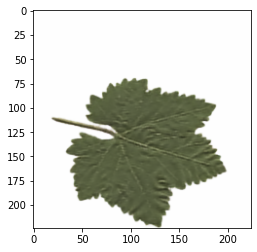

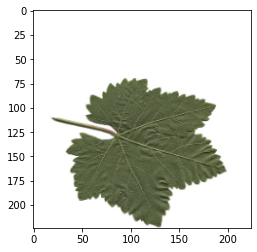

In [ ]:
X_Autoencoded = autoencoder.predict(X_train[:1])
plt.imshow(X_Autoencoded[0])
plt.show()
plt.imshow(X_train[0])

In [ ]:
X_reduced_train = encodermain.predict(X_train)
X_reduced_valid = encodermain.predict(X_valid)

In [ ]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (56,56,32)) ,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu"), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000,activation="relu"),     
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(500,activation="relu"),      
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(400,activation ="relu"),
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.3,seed = SEED),
    tf.keras.layers.Dense(5,activation = "softmax")  
])

In [ ]:
model5.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ['acc'])

In [ ]:
history5 = model5.fit(X_reduced_train, y_train,
                    validation_data=(X_reduced_valid,y_valid),
                    steps_per_epoch=len(X_reduced_train)//batch_size,
                    epochs=50,
                    validation_steps=len(X_reduced_valid)//batch_size,
                    verbose=1)

Epoch 1/50
110/110 [==============================] - 3s 17ms/step - loss: 1.7389 - acc: 0.2082 - val_loss: 1.6100 - val_acc: 0.2102
Epoch 2/50
110/110 [==============================] - 1s 12ms/step - loss: 1.6546 - acc: 0.2088 - val_loss: 1.6096 - val_acc: 0.2000
Epoch 3/50
110/110 [==============================] - 1s 12ms/step - loss: 1.6394 - acc: 0.2128 - val_loss: 1.6061 - val_acc: 0.2148
Epoch 4/50
110/110 [==============================] - 1s 12ms/step - loss: 1.6268 - acc: 0.2060 - val_loss: 1.6037 - val_acc: 0.2375
Epoch 5/50
110/110 [==============================] - 1s 12ms/step - loss: 1.6194 - acc: 0.2227 - val_loss: 1.5995 - val_acc: 0.3034
Epoch 6/50
110/110 [==============================] - 1s 13ms/step - loss: 1.6097 - acc: 0.2330 - val_loss: 1.5942 - val_acc: 0.3398
Epoch 7/50
110/110 [==============================] - 1s 12ms/step - loss: 1.6048 - acc: 0.2375 - val_loss: 1.5822 - val_acc: 0.3239
Epoch 8/50
110/110 [==============================] - 1s 12ms/step - 

In [ ]:
result = model5.evaluate(X_reduced_test, y_test)
print(dict(zip(model5.metrics_names, result)))
y_pred = model5.predict(X_reduced_test)
get_confusion_matrix(y_test, y_pred)

4/4 [==============================] - 0s 5ms/step - loss: 2.3791 - acc: 0.6600
{'loss': 2.3791327476501465, 'acc': 0.6600000262260437}
4/4 [==============================] - 0s 4ms/step
tf.Tensor(
[[14  0  2  0  0]
 [ 1  9  2  4  4]
 [ 1  0 17  4  0]
 [ 0  0  5 11  6]
 [ 1  0  1  3 15]], shape=(5, 5), dtype=int32)


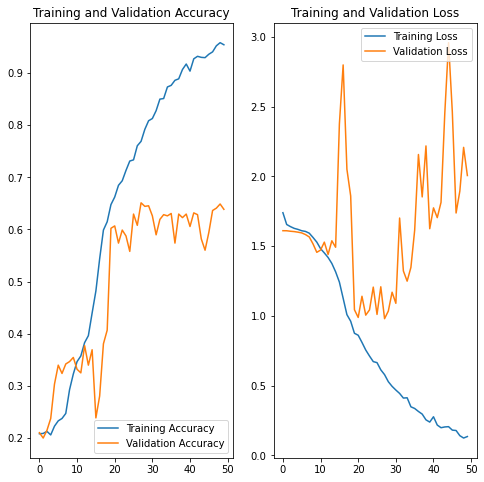

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (img_size,img_size,3)) ,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu"), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000,activation="relu"),     
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(500,activation="relu"),      
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(400,activation ="relu"),
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.3,seed = SEED),
    tf.keras.layers.Dense(5,activation = "softmax")   
])

In [ ]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])

In [ ]:
history3 = model3.fit(X_reduced_train, y_train,
                    validation_data=(X_reduced_valid,y_valid),
                    steps_per_epoch=len(X_train)//batch_size,
                    epochs=50,
                    validation_steps=len(X_valid)//batch_size,
                    verbose=1)

Epoch 1/50
110/110 [==============================] - 3s 19ms/step - loss: 3.3238 - acc: 0.2142 - val_loss: 1.6254 - val_acc: 0.2023
Epoch 2/50
110/110 [==============================] - 2s 16ms/step - loss: 1.6754 - acc: 0.2119 - val_loss: 1.6094 - val_acc: 0.2364
Epoch 3/50
110/110 [==============================] - 2s 16ms/step - loss: 1.6126 - acc: 0.2210 - val_loss: 1.6180 - val_acc: 0.2341
Epoch 4/50
110/110 [==============================] - 2s 16ms/step - loss: 1.6185 - acc: 0.2159 - val_loss: 1.6079 - val_acc: 0.2398
Epoch 5/50
110/110 [==============================] - 2s 16ms/step - loss: 1.6054 - acc: 0.2304 - val_loss: 1.6086 - val_acc: 0.2250
Epoch 6/50
110/110 [==============================] - 2s 16ms/step - loss: 1.6060 - acc: 0.2278 - val_loss: 1.6039 - val_acc: 0.2352
Epoch 7/50
110/110 [==============================] - 2s 16ms/step - loss: 1.6071 - acc: 0.2261 - val_loss: 1.6039 - val_acc: 0.2239
Epoch 8/50
110/110 [==============================] - 2s 16ms/step - 

In [ ]:
X_reduced_test = encodermain.predict(X_test)

4/4 [==============================] - 0s 24ms/step


In [ ]:
result = model3.evaluate(X_reduced_test, y_test)
print(dict(zip(model3.metrics_names, result)))
y_pred = model3.predict(X_reduced_test)
get_confusion_matrix(y_test, y_pred)

4/4 [==============================] - 0s 27ms/step - loss: 1.3742 - acc: 0.6200
{'loss': 1.3742390871047974, 'acc': 0.6200000047683716}
4/4 [==============================] - 0s 4ms/step
tf.Tensor(
[[15  0  0  1  0]
 [ 3 13  0  4  0]
 [ 3  0 13  6  0]
 [ 4  3  0 15  0]
 [ 4  0  2  8  6]], shape=(5, 5), dtype=int32)


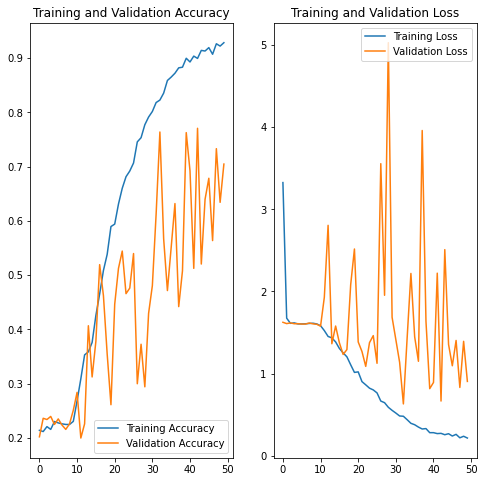

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **K-fold cross validation**


In [ ]:
img_size = 110

In [ ]:
image_size = (110,110)
batch_size = 32
all_ds = tf.keras.preprocessing.image_dataset_from_directory(
    input_dir,
    seed=SEED,
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
)

Found 500 files belonging to 5 classes.


In [ ]:
X_all = []
y_all = []

for x,y in all_ds.unbatch():
  X_all.append(x)
  y_all.append(y)

X_all = np.array(X_all)
y_all = np.array(y_all)
X_train,X_test,y_train,y_test = train_test_split(X_all, y_all, test_size=0.2)
X_all = []
y_all = []
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
train_datagen = ImageDataGenerator(width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.2,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         vertical_flip = True,
                         rescale=1./255)
rescale_datagen = ImageDataGenerator(rescale=1./255)
new_X_train = []
new_y_train = []
for i in range(400):
  x = np.array(X_train[i])
  x = np.expand_dims(x, 0)
  imgenerator = train_datagen.flow(x, batch_size = 1)
  for j in range(7):
    batch = imgenerator.next()
    new_X_train.append(batch[0])
    new_y_train.append(y_train[i])
X_test = X_test/255
X_train = X_train / 255
X_train,X_valid,y_train,y_valid = train_test_split(np.concatenate((X_train,new_X_train)), np.concatenate((y_train,new_y_train)), test_size=0.2)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
X_train = np.array(X_train)
y_train = np.array(y_train)
new_X_train = []
new_y_train = []

In [ ]:
kf = KFold(n_splits=10, shuffle=True, )
X = np.concatenate((X_train, X_valid))
y = np.concatenate((y_train, y_valid))
results = []
histories = []
for train_index, test_index in kf.split(X):
  X_train, X_valid = X[train_index], X[test_index]
  y_train, y_valid = y[train_index], y[test_index]
  model4 = 0
  model4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (img_size,img_size,3)) ,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu"), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000,activation="relu"),   
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(500,activation="relu"),   
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(400,activation ="relu"),
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dropout(0.5,seed = SEED),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.3,seed = SEED),
    tf.keras.layers.Dense(5,activation = "softmax") 
])
  model4.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ['acc'])
  history4 = model4.fit(X_train, y_train,
                    validation_data=(X_valid,y_valid),
                    steps_per_epoch=len(X_train)//10,
                    epochs=20,
                    batch_size=10,
                    validation_steps=len(X_valid)//batch_size,
                    validation_batch_size=10,
                    verbose=1)
  print(history4)
  result = model4.evaluate(X_test, y_test)
  results.append(result)
  histories.append(history4)
  print(dict(zip(model4.metrics_names, result)))
  y_pred = model4.predict(X_test)
  get_confusion_matrix(y_test, y_pred)

Epoch 1/20
288/288 [==============================] - 16s 9ms/step - loss: 2.1975 - acc: 0.2062 - val_loss: 1.6102 - val_acc: 0.2000
Epoch 2/20
288/288 [==============================] - 2s 8ms/step - loss: 1.8017 - acc: 0.1955 - val_loss: 1.5954 - val_acc: 0.2800
Epoch 3/20
288/288 [==============================] - 2s 8ms/step - loss: 1.7222 - acc: 0.2108 - val_loss: 1.6017 - val_acc: 0.2100
Epoch 4/20
288/288 [==============================] - 2s 8ms/step - loss: 1.6761 - acc: 0.2201 - val_loss: 1.6013 - val_acc: 0.2700
Epoch 5/20
288/288 [==============================] - 2s 8ms/step - loss: 1.6636 - acc: 0.2115 - val_loss: 1.6009 - val_acc: 0.2200
Epoch 6/20
288/288 [==============================] - 2s 8ms/step - loss: 1.6583 - acc: 0.2083 - val_loss: 1.6036 - val_acc: 0.2100
Epoch 7/20
288/288 [==============================] - 2s 8ms/step - loss: 1.6373 - acc: 0.2184 - val_loss: 1.6020 - val_acc: 0.2300
Epoch 8/20
288/288 [==============================] - 2s 8ms/step - loss: 1

In [ ]:
avg_accuracy = 0
avg_loss = 0
avg_valid_accuracy = 0
avg_valid_loss = 0
for i in range(10):
  avg_accuracy += history4.history['acc'][-1]
print(avg_accuracy / 10)

0.3673610985279083
